In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

font = {'size'   : 14}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42

In [2]:
# root directory where processed mutation data are stored
# if using the zenodo data, this should point to the location of the base zenodo directory (including wes, wgs, etc subfolders)
data_dir = ""

save_plots = False
# directory where you want to save pdf versions of the plots (only use if save_plots = TRUE)
plots_dir = ""

In [4]:
filtered_maf_WGS = pd.read_csv(data_dir+"wgs/combined_noshared_FILTERED_muts_WGS.maf", sep="\t")

/share/software/user/open/py-jupyter/1.0.0_py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (82,84,85,87,119) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
def compute_binomial_bayes_CI(successes, failures, width=0.95):
    upper_quantile = 1 - (1-width)/2
    lower_quantile = (1-width)/2
    lower, upper = stats.beta.ppf([lower_quantile, upper_quantile], 1+successes, 1+failures)
    return lower, upper

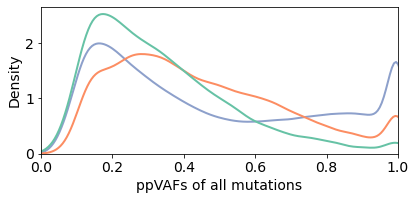

/tmp/ipykernel_26505/1390263731.py:14: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=to_plot, x="purity_ccf", hue_order=["Mucosa", "Benign", "Dysplasia"], palette="Set2", hue="Stage", ax=ax, common_norm=False, legend=False, linewidth=2)


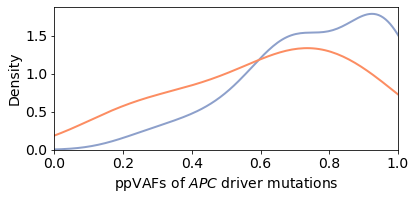

In [6]:
# FIGURE 1d

fig, ax = plt.subplots(1,1,figsize=(6,3))
sns.kdeplot(data=filtered_maf_WGS, x="purity_ccf", hue_order=["Mucosa", "Benign", "Dysplasia"], palette="Set2", hue="Stage", ax=ax, common_norm=False, legend=False, linewidth=2)
plt.xlabel("ppVAFs of all mutations")
plt.xlim(0,1)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"Fig1d_ppvaf_dists.pdf")
plt.show()

to_plot = filtered_maf_WGS[np.logical_and(filtered_maf_WGS["Driver"], filtered_maf_WGS["Hugo_Symbol"] == "APC")]
fig, ax = plt.subplots(1,1,figsize=(6,3))
sns.kdeplot(data=to_plot, x="purity_ccf", hue_order=["Mucosa", "Benign", "Dysplasia"], palette="Set2", hue="Stage", ax=ax, common_norm=False, legend=False, linewidth=2)
plt.xlabel("ppVAFs of $APC$ driver mutations")
plt.xlim(0,1)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"Fig1d_APC_dists.pdf")
plt.show()

APC


/tmp/ipykernel_26505/3541939757.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_driver["isclonal_CI"] = only_driver["purity_upper"] == 1
/tmp/ipykernel_26505/3541939757.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_driver["isclonal_call"] = np.isin(only_driver["purity_clonal"], ["CLONAL+", "CLONAL-"])


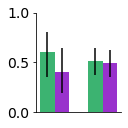

KRAS


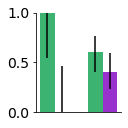

FBXW7


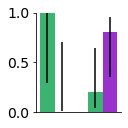

In [7]:
# FIGURE 1g
drivers_to_plot = ["APC", "KRAS", "FBXW7"]

clonal_color = "darkorchid"
subclonal_color = "mediumseagreen"
color_array = [subclonal_color, clonal_color, subclonal_color, clonal_color]

dodge = 0.15
to_plot_x = [0 - dodge, 0 + dodge, 1 - dodge, 1 + dodge]
for driver in drivers_to_plot:
    only_driver = filtered_maf_WGS[np.logical_and(filtered_maf_WGS["Driver"], filtered_maf_WGS["Hugo_Symbol"] == driver)]
    only_driver["isclonal_CI"] = only_driver["purity_upper"] == 1
    only_driver["isclonal_call"] = np.isin(only_driver["purity_clonal"], ["CLONAL+", "CLONAL-"])
    only_benign = only_driver[only_driver["Stage"]=="Benign"]
    only_dysplasia = only_driver[only_driver["Stage"]=="Dysplasia"]
    
    benign_subclonal = np.sum(~only_benign["isclonal_CI"])
    benign_clonal = np.sum(only_benign["isclonal_CI"])
    dysplasia_subclonal = np.sum(~only_dysplasia["isclonal_CI"])
    dysplasia_clonal = np.sum(only_dysplasia["isclonal_CI"])
    
    to_plot_y = np.array([benign_subclonal/(benign_subclonal+benign_clonal), benign_clonal/(benign_subclonal+benign_clonal), dysplasia_subclonal/(dysplasia_subclonal+dysplasia_clonal), dysplasia_clonal/(dysplasia_subclonal+dysplasia_clonal)])
    to_plot_errors = np.transpose(np.array([compute_binomial_bayes_CI(benign_subclonal, benign_clonal), compute_binomial_bayes_CI(benign_clonal, benign_subclonal), compute_binomial_bayes_CI(dysplasia_subclonal, dysplasia_clonal), compute_binomial_bayes_CI(dysplasia_clonal, dysplasia_subclonal)]))
    to_plot_errors[0,:] = to_plot_y - to_plot_errors[0,:]
    to_plot_errors[1,:] = to_plot_errors[1,:] - to_plot_y
    
    print(driver)
    
    fig, ax = plt.subplots(1,1,figsize=(2,2))
    plt.bar(x=to_plot_x, height=to_plot_y, yerr=to_plot_errors, color=color_array, width=dodge*2)
    plt.xlabel("")
    plt.xticks([])
    plt.ylim(0,1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    if save_plots:
        plt.savefig(plots_dir+"Fig1g_"+driver+"_clonal_CI_bar.pdf")
    plt.show()
